## Basic Multitaper

The Thomson multitaper method makes use of the dpss tapers to compute a set of approximately independent single-taper spectrum estimates (Thomson, 1982). These are then averaged together with or without weighting, to produce a single estimate. This estimate has superior statistical properties than the individual estimates, being distributed as a $\chi^2_{\nu}$ random variable, where $\nu \approx 2K$. 

Explicitly, suppose $x(t)$ is a time series for which we have $N$ discrete samples, $t = 0, \ldots, N-1$, one first computes the eigencoefficients (stored as an <tt>ecoef</tt> struct in Multitaper.jl) as
\begin{equation} \label{eq:eCoeffs}
y^{(k)}(f) = \sum_{t=0}^{N-1} x_t v_t^{(k)} e^{-i2\pi f t},
\end{equation}
and the eigenspectra as 
\begin{equation} \label{eq:eSpec}
\hat{S}^{(k)}(f) = |y^{(k)}(f)|^2,
\end{equation} 
the multitaper spectrum estimate is constructed as the following weighted average (<tt>mtspec</tt> struct in Multitaper.jl)
\begin{equation} \label{eq:MT}
\hat{S}(f) = \frac{\sum_{k=0}^{K-1} d_k^2(f)\hat{S}^{(k)}(f)}{\sum_{k=0}^{K-1} d_k^2(f)}
\end{equation}

Explicitly, the multitaper estimator uses dpss tapers to control the bias (leakage) of the spectrum estimate, and averaging to control the variance. An attractive property of multitaper estimators that is not shared by single taper estimates is consistency, i.e. the variance decreases with increasing $K$ - if you have chosen $K = 2NW$ this means that more samples gives a less variable estimate. 

In this notebook, we show an example of computing univariate multitaper spectrum estimates from the literature. By jackknifing, Multitaper.jl implements confidence intervals for the spectrum. We also show how to use the related tool, harmonic F-testing, with which to search for discrete oscillations in the data, see either of the references below. 

In [ ]:
using Multitaper, DelimitedFiles, Plots
include(dirname(dirname(pathof(Multitaper)))*"/Examples/pgram.jl")
2include(dirname(dirname(pathof(Multitaper)))*"/Examples/single_tapers.jl")

## Example: Willamette River data

We will be using the data from Don Percival's website. If you're following along in the Percival and Walden 1993 textbook, you'll find this particular example on page 512. If not, just keep reading.

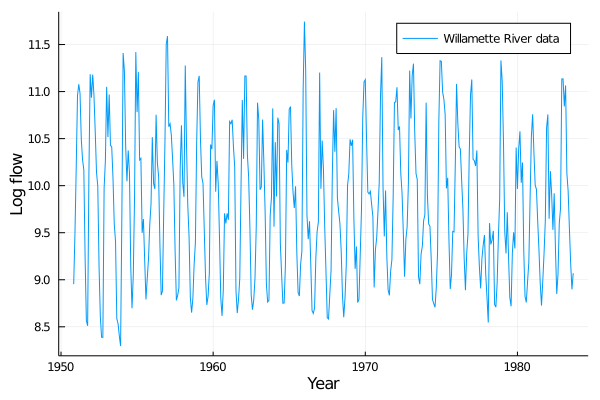

In [3]:
fn        = dirname(dirname(pathof(Multitaper)))*"/Examples/data/Willamette.dat"
riverdata = readdlm(fn,skipstart=8)[:,1]

plot(1950.0 .+ 10.0/12 .+ (0.0:(length(riverdata)-1))/12.0, riverdata, 
    label = "Willamette River data", xlabel = "Year", ylabel = "Log flow")

Here is how one computes a multitaper spectrum estimate. This one here is a high resolution estimate - careful, it has variance that explodes with an increasing number of samples. 

I have chosen a time-bandwidth product of 4 as was chosen in the textbook, and 5 tapers. I have also chosen to pad the data with twice as many zeros as the length of the data, which has an interpolating effect in the frequency domain. I have also turned on the jackknife toggle, so we can see the confidence intervals, as well as the Ftest for harmonic components. 

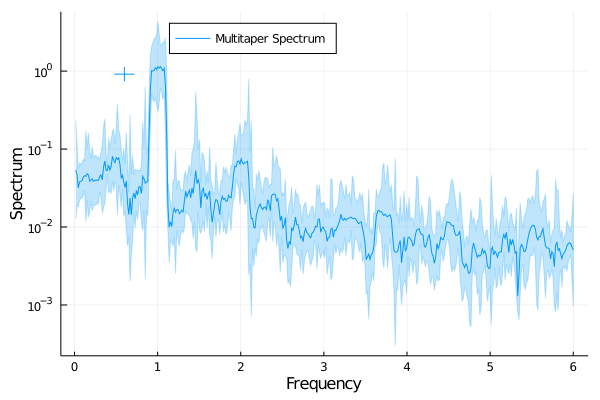

In [4]:
NW  = 4.0
K   = 5
pad = 2.0
S   = multispec(riverdata, dt = 1/12.0, NW = NW, K = K, jk = true, Ftest = true, guts = true, a_weight=true,
      pad = pad)

p = plot(S, legend = :top, label = "Multitaper Spectrum")

The multitaper estimate has peaks at the yearly cycle and twice yearly cycle which are about twice the bandwidth wide. Recall from the previous notebook that the dpss's are concentrated on the band $(-W,W)$ so one gets a spectral window that is the average of the dpss's and it looks approximately square. The spectral window is convolved with the true spectrum to give us the estimate that we see. There is no unbiased spectrum estimation, but one can get a bit less bias by decreasing the bandwidth choice (unfortunately this is balanced out by increasing the variance!)

Note that the little cross in the top left is visually showing us the bandwidth (horizontal) and expected variance (vertical) of our spectrum estimate. 

The F-test for harmonic components can be plotted in the following way. Note that the plot gives us p-values and not the raw test statistic. Let's find the frequencies where there are significant p-values. This means that there are likely sinusoidal oscillations at those frequencies (provided the spectrum is also large at that frequency.)

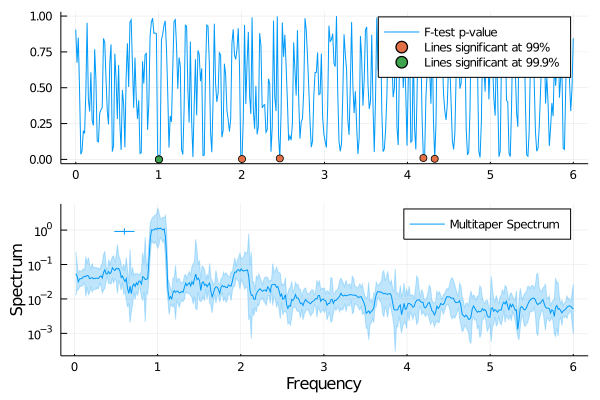

In [5]:
# Plot the p-value of the F-test
q = plot(S.f, S.Fpval, label = "F-test p-value")

# Find the peaks in the F-test above 99% and 99.9% significance
Pks99 = findall(S.Fpval .< 0.01)
q = scatter!(S.f[Pks99], S.Fpval[Pks99], label="Lines significant at 99%")
Pks999 = findall(S.Fpval .< 0.001)
q = scatter!(S.f[Pks999], S.Fpval[Pks999], label="Lines significant at 99.9%")

# Show both plots together
plot(q, p, layout=(2,1), legend = :topright)

If desired, you can easily plot the test statistic with the following commands.

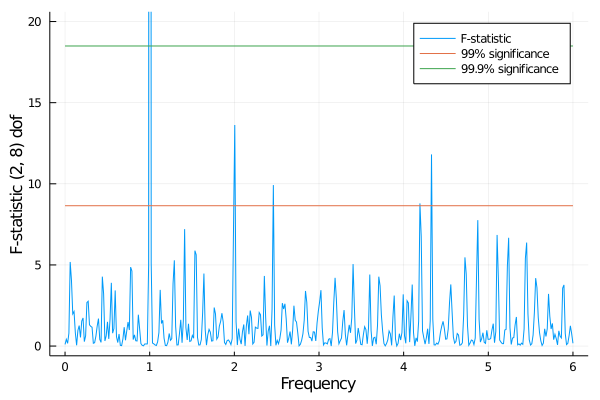

In [6]:
using Distributions

plot(S.f, quantile.(FDist(2,2*K-2), 1.0 .- S.Fpval), xlabel = "Frequency", 
    ylabel = "F-statistic (2, $(2*K-2)) dof", label = "F-statistic", 
    ylims = [0,20])
plot!(S.f[[1, end]], kron(quantile.(FDist(2, 2*K-2), [0.99 0.999]), ones(2,1)),
    label = ["99% significance" "99.9% significance"], legend = :topright)

As was found in Percival and Walden, there are discrete line components at 1 and 2 cycles per year. However, there are other interesting artifacts in these data that are visible from this F-test. Do consult the text for an interesting discussion. To avoid excessive numbers of false positives, a simple rule of thumb is to set alpha less than $1-1/N$. 

# References

Thomson, David J. "Spectrum estimation and harmonic analysis." Proceedings of the IEEE 70.9 (1982): 1055-1096.

Percival, Donald B., and Andrew T. Walden. Spectral analysis for physical applications. Cambridge University press, 1993.